In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
import librosa
import librosa.display
import random
import torchaudio, torch

/home.stud/yermaand/.conda/envs/dev/lib/python3.9/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
audio_file = 'data/audio/20190819-Kutna Hora-L4-out-MVI_0040.wav'
labels_file = 'data/labels/20190819-Kutna Hora-L4-out-MVI_0040.txt'

signal, sr = torchaudio.load(audio_file)
signal = signal.mean(0)

events = np.loadtxt(labels_file)

# window_len = 1.0

# start_time = 25 * 60
# end_time = int(1e6)

# events = events - start_time
# events = events[(events > 0) & (events < end_time)]
# events *= sr

# n_samples_per_window = int(sr * window_len)

# labels = []
# for i in range(len(signals)):
#     counts = (i * n_samples_per_window <= events) & \
#         (events < i * n_samples_per_window + n_samples_per_window)
#     counts = counts.sum()
#     labels.append(int(counts > 0))

# labels = np.array(labels)


In [72]:
signal

tensor([ 0.0155,  0.0407,  0.0638,  ..., -0.0031,  0.0081,  0.0156])

In [4]:
from experiment3.model import ResNet18

In [5]:
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')

model = ResNet18(num_classes=100).to(device)

In [53]:
weights = torch.load(f'models/model_1626692165.pth', device)
model.load_state_dict(weights)

<All keys matched successfully>

In [54]:
melkwargs = {
    "n_fft" : 1024, 
    "n_mels" : 64, 
    "hop_length": 128
}

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    **melkwargs
)

mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sr,
    n_mfcc=8,
    melkwargs=melkwargs
)

In [76]:
n_samples_per_window = int(sr * window_len)

results = []

start_time = 1 * 60
T = 9 * 60

model.eval()
with torch.no_grad():
    
    for sec in np.linspace(0, T, int(T) * 10):
        
        t = int((sec + start_time) * sr)
    
        s1 = signal[t: t + n_samples_per_window]
        
        mel_features = mel_transform(s1).unsqueeze(0)
        mfcc_features = mfcc_transform(s1).unsqueeze(0)
        s1 = torch.cat((mel_features, mfcc_features), dim=1).unsqueeze(0).to(device)

#         s1 = mfcc_transform(s1).unsqueeze(0).unsqueeze(0).to(device)
#         s1 = mel_transform(s1).unsqueeze(0).unsqueeze(0).to(device)
    
        y = model(s1).softmax(1)
        
        results.append(y)
        
#         print(torch.argmax(y).item())


# for t, r in zip(range(T), results):
#     print(start_time + t, r)
    
    

In [77]:
results = [r.cpu().numpy() for r in results]
results = np.array(results).flatten()


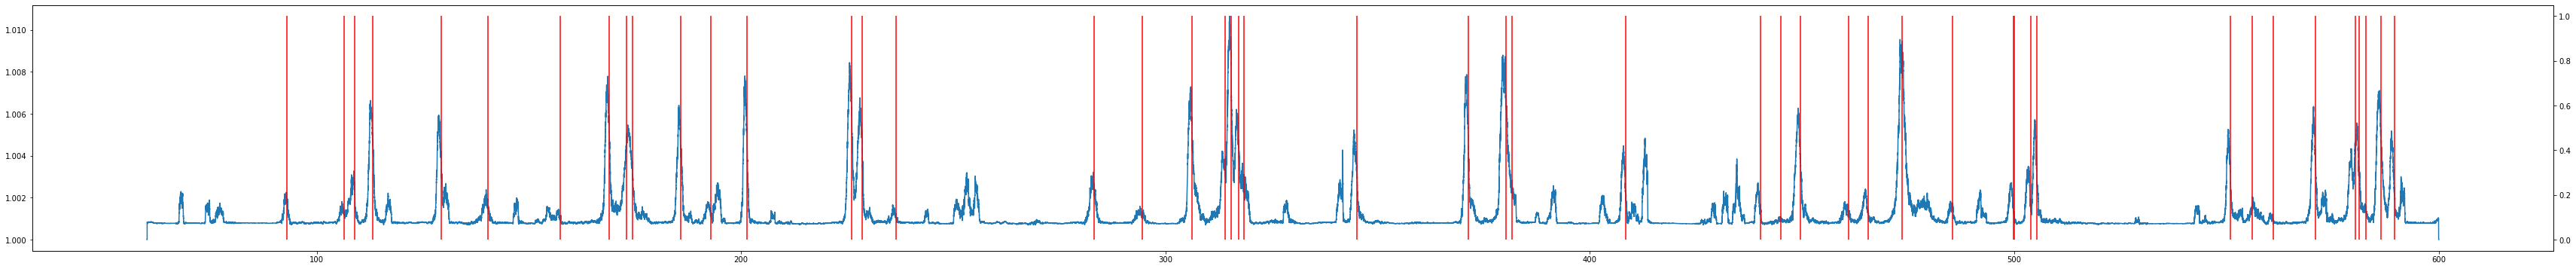

In [106]:
results_convolved = np.maximum(results, 0.01)
results_convolved = np.convolve(results_convolved, np.ones(100), 'valid')
results_convolved = np.pad(results_convolved, 50, mode='constant', constant_values=1)[:-1]

T1 = np.linspace(0, T, int(T) * 1000) + start_time

fig, ax1 = plt.subplots(figsize=(60, 6))
ax2 = ax1.twinx()

ax1.plot(T1, results_convolved);

for event in events[(events >= start_time) & (events < start_time + T)]:
    ax2.vlines(event, 0, 1, color='r')

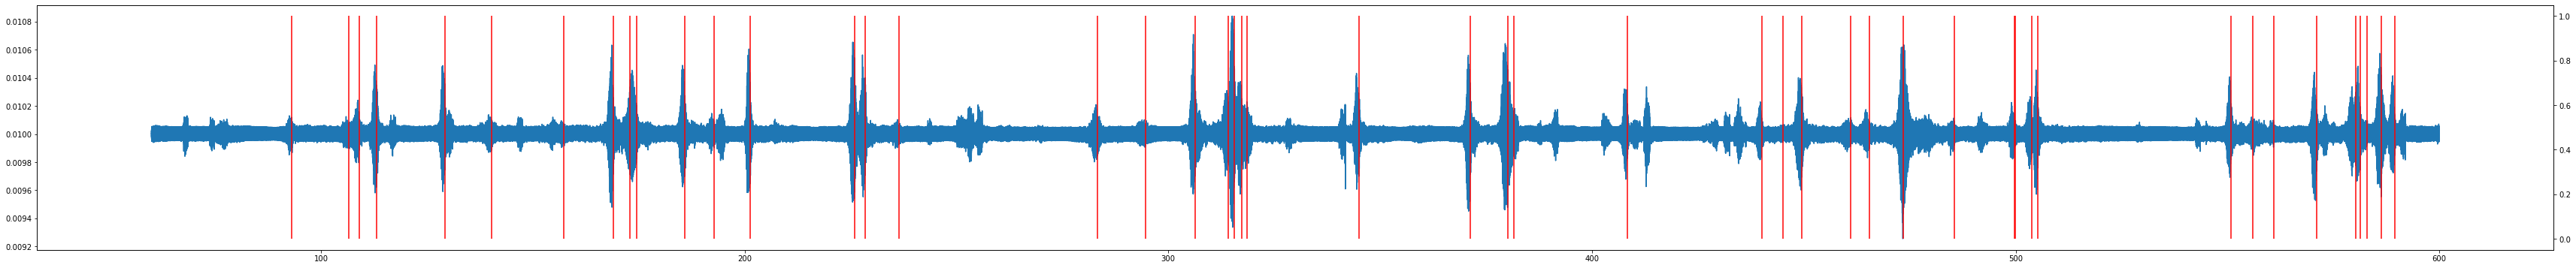

In [78]:
fig, ax1 = plt.subplots(figsize=(60, 6))
ax2 = ax1.twinx()

T1 = np.linspace(0, T, int(T) * 1000) + start_time
ax1.plot(T1, results)

for event in events[(events >= start_time) & (events < start_time + T)]:
    ax2.vlines(event, 0, 1, color='r')

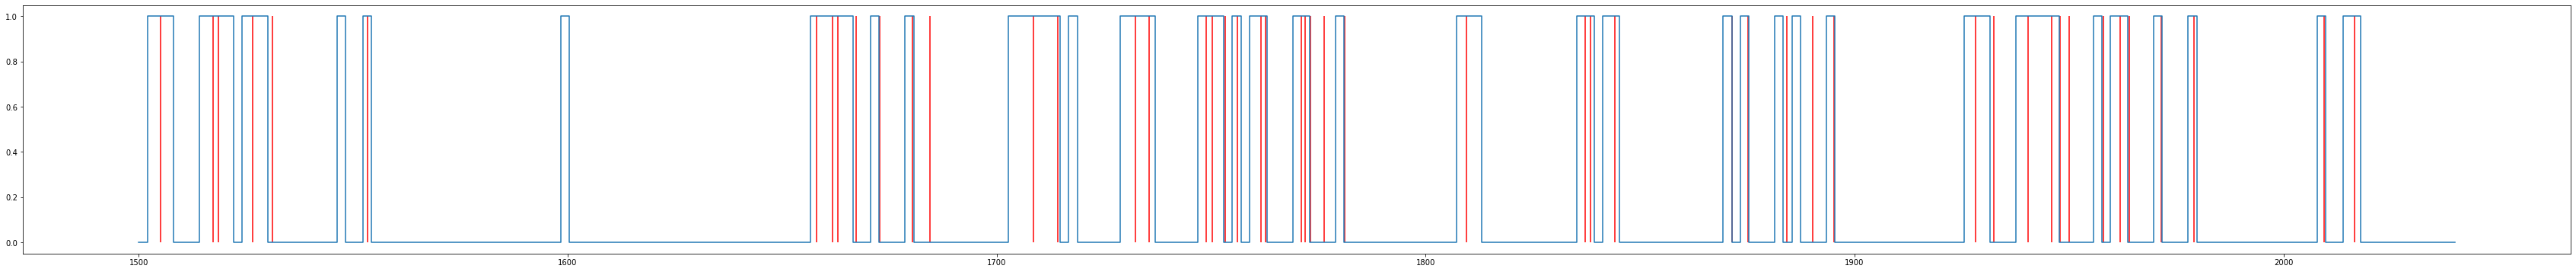

In [69]:
# T1 = np.arange(T) + start_time
T1 = np.linspace(0, T, int(T / 2)) + start_time

plt.figure(figsize=(60, 6))
plt.step(T1, results);

for event in events[(events >= start_time) & (events < start_time + T)]:
    plt.vlines(event, 0, 1, color='r')
# plt.show()

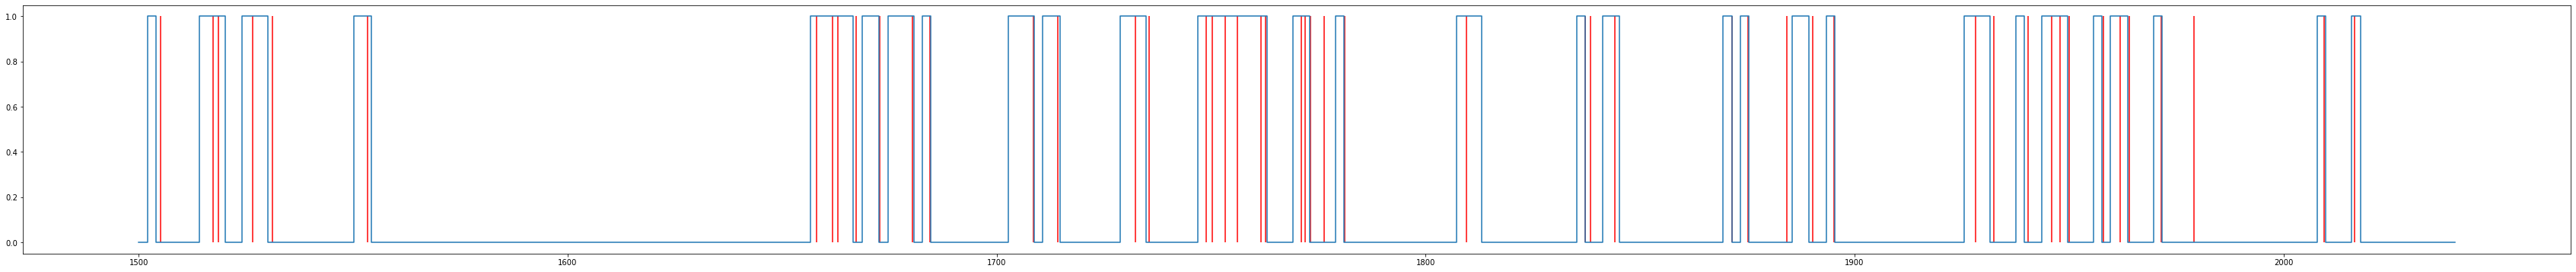

In [14]:
# T1 = np.arange(T) + start_time
T1 = np.linspace(0, T, int(T / 2)) + start_time

plt.figure(figsize=(60, 6))
plt.step(T1, results);

for event in events[(events >= start_time) & (events < start_time + T)]:
    plt.vlines(event, 0, 1, color='r')

In [28]:
# mfcc_transform(s1).unsqueeze(0)
s1 = signal[0: 0 + n_samples_per_window]
mel_features = mel_transform(s1).unsqueeze(0)
mfcc_features = mfcc_transform(s1).unsqueeze(0)

In [29]:
mel_features.shape

torch.Size([1, 64, 345])

In [30]:
mfcc_features.shape

torch.Size([1, 8, 345])

In [38]:
torch.cat((mel_features, mfcc_features), dim=1).shape

torch.Size([1, 72, 345])

In [80]:
n_samples_per_window

44100